Energy forecast with ML

In [31]:
import kaggle
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

kaggle.api.authenticate()

In [32]:
# see the available datasets in kaggle related to energy
!kaggle datasets list -s 'energy'

ref                                                             title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
robikscube/hourly-energy-consumption                            Hourly Energy Consumption                           11979477  2018-08-30 14:17:03.317000          92271       1060  1.0              
pralabhpoudel/world-energy-consumption                          World Energy Consumption                             2363711  2023-11-26 00:57:10.697000          22402        202  1.0              
unitednations/international-energy-statistics                   International Energy Statistics                      7709566  2017-11-16 00:06:06.683000          13233        289  0.7058824        
loveall/ap

In [33]:
#Download the dataset and store it in the data folder 
#kaggle.api.dataset_download_files('robikscube/hourly-energy-consumption', path='./data', unzip=True) 

In [34]:
henergy_df = pd.read_csv("..\data\AEP_hourly.csv")
henergy_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


EDA

In [35]:
# check if the data has missing values
henergy_df.notna().value_counts()

Datetime  AEP_MW
True      True      121273
dtype: int64

In [36]:
henergy_df.Datetime = pd.to_datetime(henergy_df.Datetime)
henergy_df.info

<bound method DataFrame.info of                   Datetime   AEP_MW
0      2004-12-31 01:00:00  13478.0
1      2004-12-31 02:00:00  12865.0
2      2004-12-31 03:00:00  12577.0
3      2004-12-31 04:00:00  12517.0
4      2004-12-31 05:00:00  12670.0
...                    ...      ...
121268 2018-01-01 20:00:00  21089.0
121269 2018-01-01 21:00:00  20999.0
121270 2018-01-01 22:00:00  20820.0
121271 2018-01-01 23:00:00  20415.0
121272 2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]>

In [37]:
henergy_df = henergy_df.set_index(henergy_df['Datetime'])
dates = henergy_df['Datetime']
henergy_df_nprocessed = henergy_df.copy()
henergy_df= henergy_df.drop(['Datetime'], axis=1)


In [39]:
duplocates = dates.duplicated()
henergy_df_nprocessed[henergy_df_nprocessed['Datetime'].isin(dates[duplocates])]

,Datetime,AEP_MW
Datetime,,
2014-11-02 02:00:00,2014-11-02 02:00:00,12994.0
2014-11-02 02:00:00,2014-11-02 02:00:00,13190.0
2015-11-01 02:00:00,2015-11-01 02:00:00,10785.0
2015-11-01 02:00:00,2015-11-01 02:00:00,10542.0
2016-11-06 02:00:00,2016-11-06 02:00:00,10964.0
2016-11-06 02:00:00,2016-11-06 02:00:00,11008.0
2017-11-05 02:00:00,2017-11-05 02:00:00,10596.0
2017-11-05 02:00:00,2017-11-05 02:00:00,10446.0


In [41]:
henergy_df = henergy_df_nprocessed.drop_duplicates(subset='Datetime', keep='first')
henergy_df

,Datetime,AEP_MW
Datetime,,
2004-12-31 01:00:00,2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,2004-12-31 05:00:00,12670.0
...,...,...
2018-01-01 20:00:00,2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,2018-01-01 22:00:00,20820.0


# Checking some important characteristics of the time series data.

- Trend
- Stationarity 
- Seasonality


## Trend

First I will check the trend of the time series data. There are a couple of ways to check this. Firstly I will do a visual inpspection to get to know the characteristics of the data better and see what test I can use to check the trend.

`

In [42]:
# Plot each year's time series in its own facet
def extract_time_data(df_o):
    df= df_o.copy()
    df['Year'] =  df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    return df

henergy_df = extract_time_data(henergy_df)
henergy_df.head()

,Datetime,AEP_MW,Year,Month,Day,Hour
Datetime,,,,,,
2004-12-31 01:00:00,2004-12-31 01:00:00,13478.0,2004,12,31,1
2004-12-31 02:00:00,2004-12-31 02:00:00,12865.0,2004,12,31,2
2004-12-31 03:00:00,2004-12-31 03:00:00,12577.0,2004,12,31,3
2004-12-31 04:00:00,2004-12-31 04:00:00,12517.0,2004,12,31,4
2004-12-31 05:00:00,2004-12-31 05:00:00,12670.0,2004,12,31,5


In [43]:
dates = henergy_df.index  # full datetime, avoids duplicates
dates[dates.duplicated()]

DatetimeIndex([], dtype='datetime64[ns]', name='Datetime', freq=None)

In [44]:
henergy_df = henergy_df.drop_duplicates(subset='Datetime', keep='first')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


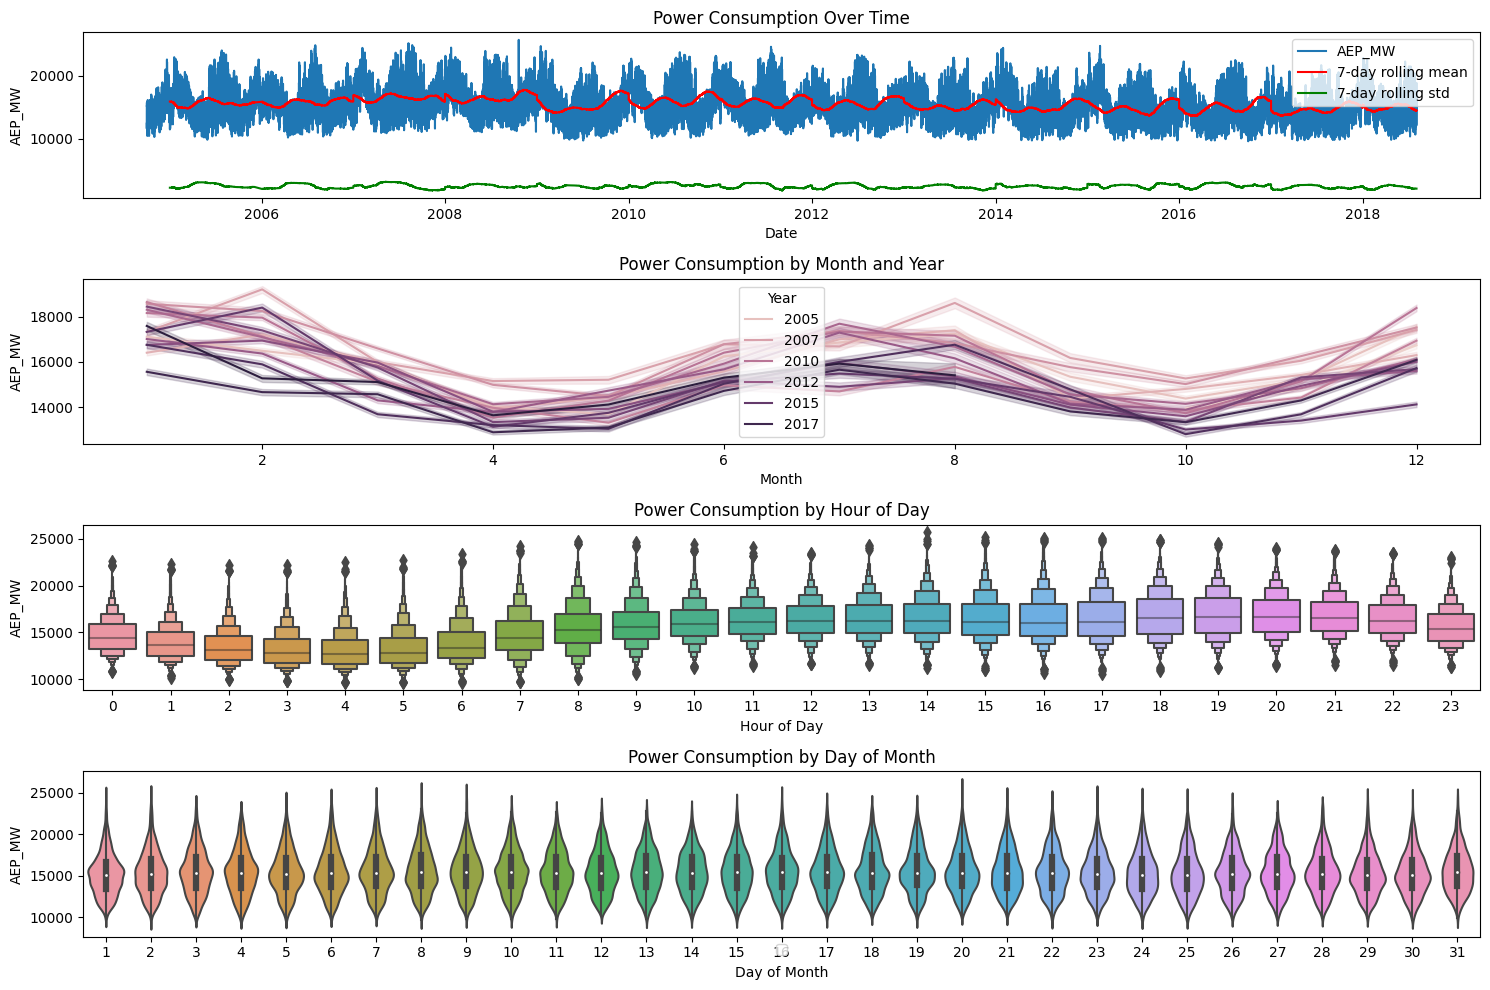

In [59]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# 1. Power consumption over time with rolling statistics
# Create rolling statistics
days = 120 # Number of days for the rolling window
rolling_window = 24*days  
rolling_mean = henergy_df['AEP_MW'].rolling(rolling_window).mean()
rolling_std = henergy_df['AEP_MW'].rolling(rolling_window).std()
dates = henergy_df.index  # full datetime, avoids duplicates
#plot the time series and rolling statistics
sns.lineplot(x=dates, y=henergy_df['AEP_MW'], ax=axs[0], label='AEP_MW')
sns.lineplot(x=dates, y=rolling_mean, ax=axs[0], color='red', label='7-day rolling mean')
sns.lineplot(x=dates, y=rolling_std, ax=axs[0], color='green', label='7-day rolling std')
axs[0].set_title("Power Consumption and Rolling Statistics")
axs[0].legend()
axs[0].set_title('Power Consumption Over Time')
axs[0].set_xlabel('Date')

# 2. Power consumption by month and year to see seasonal trends
sns.lineplot(henergy_df, y='AEP_MW', x = 'Month', hue='Year', ax=axs[1])
axs[1].set_title('Power Consumption by Month and Year')
axs[1].set_xlabel('Month')
# 3. Power consumption by hour of day to see daily trends
sns.boxenplot(henergy_df, y='AEP_MW', x = 'Hour', ax=axs[2])
axs[2].set_title('Power Consumption by Hour of Day')
axs[2].set_xlabel('Hour of Day')
# 4. Power consumption by day of month to see monthly trends
sns.violinplot(henergy_df, y='AEP_MW', x = 'Day', ax=axs[3])
axs[3].set_title('Power Consumption by Day of Month')
axs[3].set_xlabel('Day of Month')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.show()


Based on the visual inspection I can see a slight trend in the data, however is a small decrease in the energy consumption over the years. Nevertheless to check if the trend has some statistical significance I will use a statistical test. The Augmented Dickey-Fuller test is a common test to check for trend in time series data. 

years wont be used as feature of the model, nor the day of the month as they not play a significant role in the energy consumption, however the month and the hour of the day will be used as features of the model. 

ADF Statistic: -16.453074716453894
p-value: 2.368354891027987e-29
Critical Value (1%): -3.4304039570988323
Critical Value (5%): -2.861563848238303
Critical Value (10%): -2.566782693574735


Text(0.5, 0, 'Power Consumption (MW)')

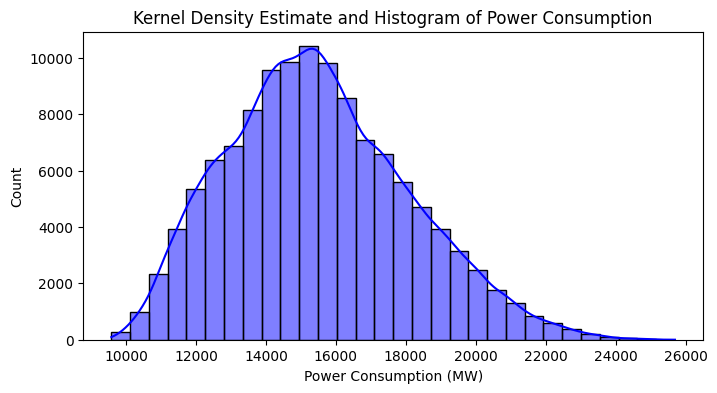

In [56]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(henergy_df['AEP_MW'].values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

print(f'ADF Statistic: {adf_stat}')
print(f'p-value: {p_val}')
print(f'Critical Value (1%): {crit_val_1}')
print(f'Critical Value (5%): {crit_val_5}')
print(f'Critical Value (10%): {crit_val_10}')


fig, ax = plt.subplots(figsize=(8, 4))
# 5. Kernel Density Estimate and Histogram of Power Consumption
sns.histplot(henergy_df['AEP_MW'], bins=30, kde=True, ax=ax, color='blue', label='Histogram')
ax.set_title('Kernel Density Estimate and Histogram of Power Consumption')
ax.set_xlabel('Power Consumption (MW)')


In [ ]:
# importing function
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# creating trend object by assuming multiplicative model
seasonal_decompose(henergy_df_nprocessed, model='multiplicative', period=12).plot()

In [ ]:
sm.graphics.tsa.plot_acf(henergy_df, lags=50)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(henergy_df, lags=100, ax=ax, method='ywm') # Plot first 20 lags
ax.set_xlabel("Lag")
ax.set_ylabel("Partial Autocorrelation")
ax.set_title("Partial Autocorrelation Function (PACF)")
plt.show() # Display the plot